In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import cv2
import pandas as pd
import numpy as np
import datetime

from keras.models import Sequential
from PIL import Image    
from tensorflow import keras
from keras import layers
from keras import utils
from glob import glob

In [2]:
# !echo 0 | sudo tee -a /sys/bus/pci/devices/0000\:00\:04.0/numa_node

In [3]:
import tensorflow as tf

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3007766346636289718,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13942652928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4690888870937202802
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
# dataset_name = "mnist"
# 반복할 횟수(1이상으로 잡아야 돌아갑니다.)
# dataset_repetitions = 3
dataset_repetitions = 1
# Epoch
num_epochs = 50
# num_epochs = 1

# resize시 정할 이미지
# image_size = 256
image_size = 256
# 데이터셋 컬러여부
# image_colored = 0
image_colored = 1
channel = 3


# KID = Kernel Inception Distance, see related section
kid_image_size = 75
# kid_image_size = 128
kid_diffusion_steps = 5
# kid_diffusion_steps = 10
plot_diffusion_steps = 20
# plot_diffusion_steps = 100
one_plot_diffusion_steps = 20
# one_plot_diffusion_steps = 100

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 2
# batch_size = 16
ema = 0.999
learning_rate = 2e-5
weight_decay = 1e-4

# class
num_class = 3
class_embedding_dims = 32

#dataset = tf.data.Dataset.from_generator(Gen,(tf.float32, tf.int8), ((256,256,6), (8)))
#val_dataset = tf.data.Dataset.from_generator(Gen,(tf.float32, tf.int8), ((256,256,6),(8)))


In [5]:
# http://www.kwangsiklee.com/2018/11/keras%EC%97%90%EC%84%9C-sequence%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%98%EC%97%AC-%EB%8C%80%EC%9A%A9%EB%9F%89-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B-%EC%B2%98%EB%A6%AC%ED%95%98%EA%B8%B0/
# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class Gen(tf.keras.utils.Sequence):

    def __init__(self, data_path, labels, batch_size= batch_size, n_channels=channel, n_classes=num_class, shuffle=True, image_size = image_size):
        self.data_path, self.labels = data_path, labels# 데이터셋 경로, 데이터 라벨 리스트
        self.batch_size = batch_size # 배치사이즈 설정
        self.n_channels = n_channels # 채널 수
        self.n_classes = n_classes # 클래스 갯수
        self.shuffle = shuffle # 각 epoch마다 새로운 order를 만들어냄
        self.image_size = image_size
        self.on_epoch_end() # 각 에포크의 맨 처음과 끝에 실행됨. 
        

    def __len__(self):
        return math.ceil(len(self.data_path) / self.batch_size)

    def __getitem__(self, index):
#         print('index : ', index)
        indexes =  self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         print(self.indexes)
#         print('indexes : ', indexes)
        # list_IDs_temp = [self.labels[k] for k in indexes]
        X, y = self.__data_generation(indexes)
        y = tf.one_hot(indices = y, depth = self.n_classes, dtype = tf.int64)
        y = np.array(y)
#         print("X shape", X.shape)
        
#         print("y shape", y.shape)
#         print(y)
        
        return (X, y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_path))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)  
            
#     def __iter__(self):
#         """Create a generator that iterate over the Sequence."""
#         for item in (self[i] for i in range(len(self))):
#             yield item        

    def crop_img (self, img, w, h):
        start = ((w // 2 - 128) , (h // 2 - 128))
        end = ((w // 2 + 128), (h // 2 + 128))
        crop_img = img[start[1]:end[1], start[0]:end[0]]
        return np.clip(crop_img/255.0, 0.0, 1.0)
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.image_size, self.image_size, self.n_channels))
        y = np.empty((self.batch_size) , dtype = int) # 메모리만 할당 받고 메모리 초기화는 하지 않는 함수 메모리 초기화를 하려면 zeros를 사용해야함.
#         print('self.batch_size :', self.batch_size)
#         print('X.shape :', X.shape)
        # Generate data
        for i, ID in enumerate(indexes):
            img = cv2.imread(self.data_path[ID])
            h,w,c = img.shape
            crop = self.crop_img(img, w, h)

            X[i, ] = crop
            y[i] = self.labels[ID]
        return X, y
            

In [6]:
# 확인용 코드
def concat_csv(csv_lists):
    
    for i, csv in enumerate(csv_lists):
        csv_df = pd.read_csv(csv)
        if i == 0:
            df = csv_df
        else:
            df = pd.concat([df, csv_df])
        df = df.sample(frac = 1).reset_index(drop=True)
    return df
            
def df_to_generator(dataframe):
    data_path = list(dataframe['data_path'])
    labels = list(dataframe['label'])

    g = Gen(data_path, labels, batch_size)
    return g



In [7]:
csv_path = 'sample/'
csv_lists = glob(csv_path + '*.csv')

dataframe = concat_csv(csv_lists)
file_count = len(dataframe)
print('file_count :', file_count)
train_df = dataframe[:int(file_count*0.8)]
display(train_df)

val_df = dataframe[int(file_count*0.8):]
display(val_df)

file_count : 32


,label,data_path
0,1,sample/hanok.jpeg
1,1,sample/hanok.jpeg
2,1,sample/hanok.jpeg
3,2,sample/hanok2.jpeg
4,1,sample/hanok.jpeg
5,0,sample/building.jpeg
6,1,sample/hanok.jpeg
7,0,sample/building.jpeg
8,1,sample/hanok.jpeg
9,1,sample/hanok.jpeg


,label,data_path
25,0,sample/building.jpeg
26,0,sample/building.jpeg
27,1,sample/hanok.jpeg
28,1,sample/hanok.jpeg
29,0,sample/building.jpeg
30,0,sample/building.jpeg
31,2,sample/hanok2.jpeg


In [8]:
train_gen = df_to_generator(train_df)
# print(train_gen)
# train_batch =  next(iter(train_gen))
# print(train_batch)

# print('--------------')

val_gen = df_to_generator(val_df)
# print(val_gen)

# val_batch  = next(iter(val_gen))
# print(val_batch)

In [9]:
print(train_gen)
print(len(train_gen))

13


In [10]:
print(next(iter(train_gen))[0].shape)
print("-------")
print(next(iter(train_gen))[1].shape)

(2, 256, 256, 3)
-------
(2, 3)


In [11]:
for t in iter(train_gen):
    print(t[0].shape)

(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)
(2, 256, 256, 3)


In [12]:
# 이미지의 너비와 높이 중 짧은 길이에 맞춰서 center crop하는 함수
def preprocess_image(data):
    c_vect = tf.one_hot(data["label"], num_class)
    # Center crop한 이미지를 Hyper parameter에서 정해준 image_size에 맞게 resize 해줍니다.
    # resize시 이미지 훼손을 최대한 방지하기 위해 antialias를 True로 해줍니다.
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    
    # 이미지 Array의 값을 float 0~1로 만들어주고 혹시 모를 특이값을 방지하기 위해 clip을 해줍니다.
    return {'image': tf.clip_by_value(image / 255.0, 0.0, 1.0), 'label' : c_vect}

In [13]:
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID 배치마다 계산되며 배치간의 값들로 평균을 냅니다.
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


In [14]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

In [15]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

In [16]:
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [17]:
def get_network(image_size, widths, num_class, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))
    class_vector = keras.Input(shape = (num_class,))
    
    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
#     print('e :', e)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
#     print('e :',e)
    
    i = layers.Dense(class_embedding_dims)(class_vector)
#     print('i :',i)
#     i = layers.Reshape((1,1,class_embedding_dims))(i)
    i = i[:,None,None,:]
#     print('i :',i)
    i = layers.UpSampling2D(size=image_size, interpolation="nearest")(i)
#     print('i :',i)
    
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, i, e])
#     print('x', x)

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)
#     x = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x)
    

    return keras.Model([noisy_images, noise_variances, class_vector], x, name="residual_unet")



In [18]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, num_class, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization(axis=None)
        self.network = get_network(image_size, widths, num_class, block_depth)
        self.ema_network = keras.models.clone_model(self.network)
        
    def call(self, data, training=False):
        
        pass
    
    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, class_vector, training):
        # print("denoise start")
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        # pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_noises = network([noisy_images, noise_rates**2, class_vector], training=training)
        # print("denoise get noises")
    
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        # print("denoise get images") 
        
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps, class_vector):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, class_vector, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps, class_vector):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps, class_vector)
        generated_images = self.denormalize(generated_images)
        return generated_images

    # def train_step(self, images):
    def train_step(self, data):
        # normalize images to have standard deviation of 1, like the noises
        # print("train_step start")
        
        #images = data['image']
        #label = data['label']
        print('data :', data)
        images, label = data
        print('images :', images)
        print('label :', label)
        
        print('image.shape :', images.shape)
        
        images = self.normalizer(images, training = True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # print("train_step here 1")
        # print("noise_rates :", noise_rates)
        # print("signal_rates :", signal_rates)
        # print("noisy_images :", noisy_images)
        
        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, label, training=True
            )
            # print('start get loss')
            noise_loss = self.loss(noises, pred_noises)  # used for training
            # print('get noise loss')
            image_loss = self.loss(images, pred_images)  # only used as metric
            # print('get image loss')
            
            
        # print("train_step here 2")
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)
    
        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    # def test_step(self, images):
    def test_step(self, data):
#         images = data['image']
#         label = data['label']
        images, label = data
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, label, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps, class_vector = label
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    # plot random generated images for visual evaluation of generation quality
    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=1):
    # def plot_images(self, epoch=None, logs=None, num_rows=1, num_cols=5):
        
        # indices = [0,1,2,3,4,5,6,7]
        indices = [0,1,2]
        sample_vector = tf.one_hot(indices, num_class)
        # sample_vector shape (10,10)
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
            class_vector =  sample_vector 
        )
        # generated_images shape : (10,32,32,3)

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
        
    def plot_one_images(self, input_class = 0, epoch=None, logs=None):
        
        index = [input_class]
        sample_vector = tf.one_hot(index, num_class)
        # sample_vector shape : (1,10)
            
        generated_images = self.generate(
            num_images=1,
            diffusion_steps = one_plot_diffusion_steps,
            class_vector =  sample_vector 
        )
        # generated_images shape : (1,32,32,3)
        
        plt.figure(figsize=(6,6))
        plt.imshow(generated_images[0])
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()


In [19]:
# !pip install tensorflow_addons

In [20]:
import tensorflow_addons as tfa

# create and compile the model
model = DiffusionModel(image_size, widths, num_class, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=tfa.optimizers.AdamW(
#     optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.MeanSquaredError(),
)
# pixelwise mean absolute error is used as loss


In [21]:
# save the best model based on the validation KID metric
checkpoint_path = "checkpoint/diffusion_model"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

In [22]:
# calculate mean and variance of training dataset for normalization
# 이미지와 label로 데이터셋의 형태가 변하였기 때문에 image만 가져와서 adapt 시켜줍니다.
# train_image = train_gen.map(lambda x : x, y)
# model.normalizer.adapt(train_gen)# run training and plot generated images periodically

Epoch 1/50
data : (<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=int64>)
images : Tensor("IteratorGetNext:0", shape=(None, None, None, None), dtype=float32)
label : Tensor("IteratorGetNext:1", shape=(None, None), dtype=int64)
image.shape : (None, None, None, None)
data : (<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=int64>)
images : Tensor("IteratorGetNext:0", shape=(None, None, None, None), dtype=float32)
label : Tensor("IteratorGetNext:1", shape=(None, None), dtype=int64)
image.shape : (None, None, None, None)
13/13 [==============================] - 38s 686ms/step - n_loss: 0.9994 - i_loss: 21.8236 - val_n_loss: nan - val_i_loss: nan - val_kid: nan


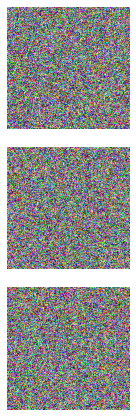

Epoch 2/50
13/13 [==============================] - 2s 167ms/step - n_loss: 0.9967 - i_loss: 30.8476 - val_n_loss: 0.9973 - val_i_loss: 1.4008 - val_kid: 2.4349


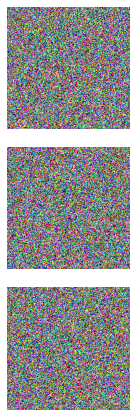

Epoch 3/50
13/13 [==============================] - 2s 168ms/step - n_loss: 0.9931 - i_loss: 20.3143 - val_n_loss: 1.0004 - val_i_loss: 58.3815 - val_kid: 2.7669


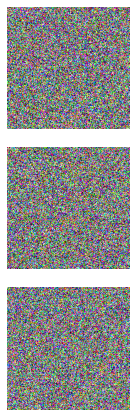

Epoch 4/50
13/13 [==============================] - 2s 167ms/step - n_loss: 0.9869 - i_loss: 48.7671 - val_n_loss: 0.9992 - val_i_loss: 3.4791 - val_kid: 2.0026


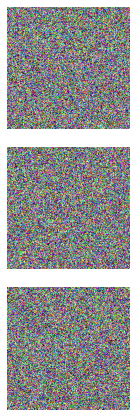

Epoch 5/50
13/13 [==============================] - 2s 168ms/step - n_loss: 0.9804 - i_loss: 30.3660 - val_n_loss: 1.0006 - val_i_loss: 2.9262 - val_kid: 3.4053


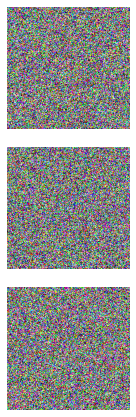

Epoch 6/50
13/13 [==============================] - 2s 169ms/step - n_loss: 0.9716 - i_loss: 70.8933 - val_n_loss: 1.0006 - val_i_loss: 75.1634 - val_kid: 3.5102


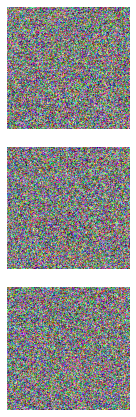

Epoch 7/50
13/13 [==============================] - 2s 169ms/step - n_loss: 0.9602 - i_loss: 23.5177 - val_n_loss: 0.9993 - val_i_loss: 86.0452 - val_kid: 4.1633


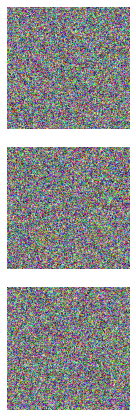

Epoch 8/50
13/13 [==============================] - 2s 169ms/step - n_loss: 0.9425 - i_loss: 11.6234 - val_n_loss: 1.0002 - val_i_loss: 5.3149 - val_kid: 2.5138


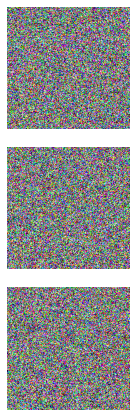

Epoch 9/50
13/13 [==============================] - 2s 170ms/step - n_loss: 0.9240 - i_loss: 13.3998 - val_n_loss: 1.0008 - val_i_loss: 4.2462 - val_kid: 3.4841


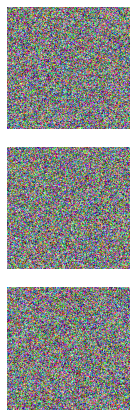

Epoch 10/50
13/13 [==============================] - 2s 170ms/step - n_loss: 0.9029 - i_loss: 43.3380 - val_n_loss: 1.0001 - val_i_loss: 2.9971 - val_kid: 4.9808


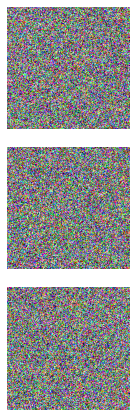

Epoch 11/50
13/13 [==============================] - 2s 171ms/step - n_loss: 0.8856 - i_loss: 21.4763 - val_n_loss: 0.9994 - val_i_loss: 29.9364 - val_kid: 2.0706


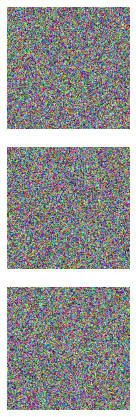

Epoch 12/50
13/13 [==============================] - 2s 164ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


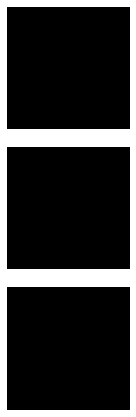

Epoch 13/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


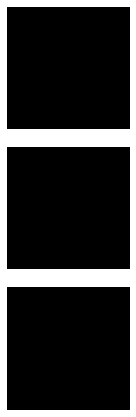

Epoch 14/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


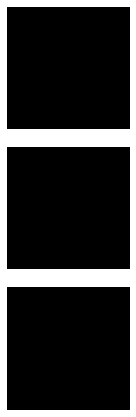

Epoch 15/50
13/13 [==============================] - 2s 160ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


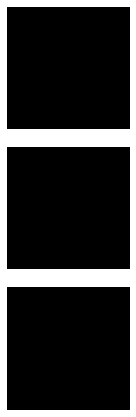

Epoch 16/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


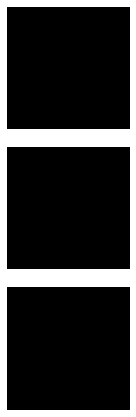

Epoch 17/50
13/13 [==============================] - 2s 160ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


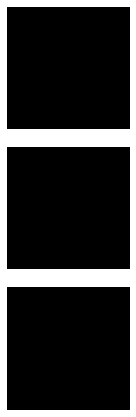

Epoch 18/50
13/13 [==============================] - 2s 160ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


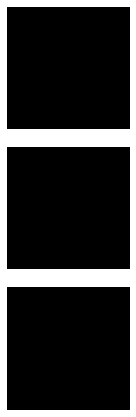

Epoch 19/50
13/13 [==============================] - 2s 160ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


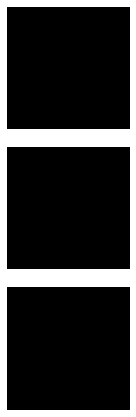

Epoch 20/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


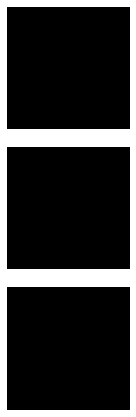

Epoch 21/50
13/13 [==============================] - 2s 160ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


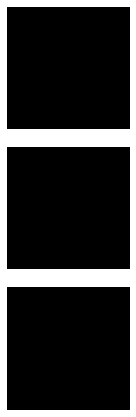

Epoch 22/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


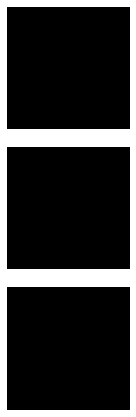

Epoch 23/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


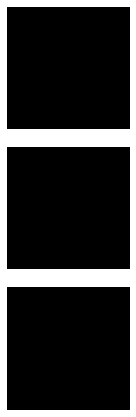

Epoch 24/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


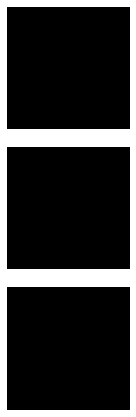

Epoch 25/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


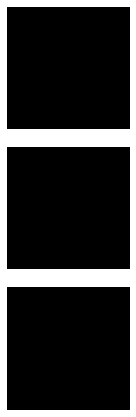

Epoch 26/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


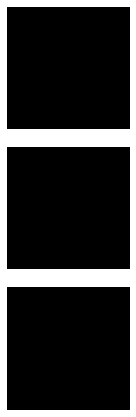

Epoch 27/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


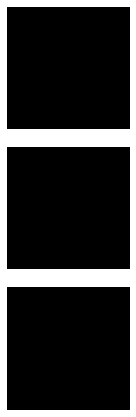

Epoch 28/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


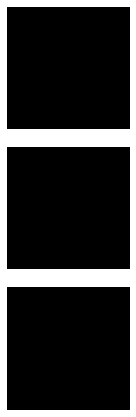

Epoch 29/50
13/13 [==============================] - 3s 205ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


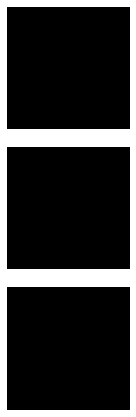

Epoch 30/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


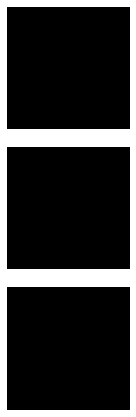

Epoch 31/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


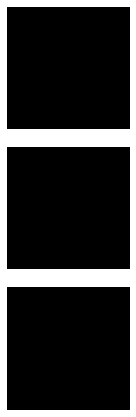

Epoch 32/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


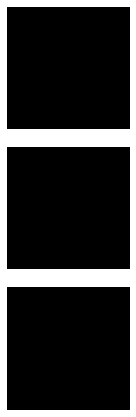

Epoch 33/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


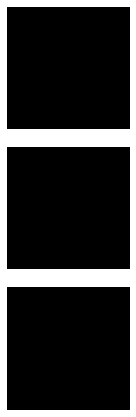

Epoch 34/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


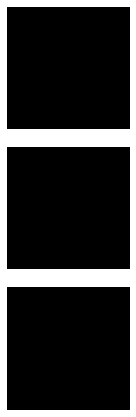

Epoch 35/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


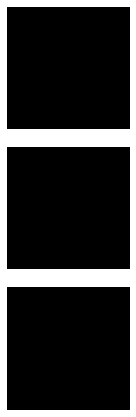

Epoch 36/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


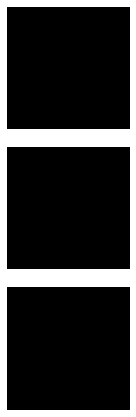

Epoch 37/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


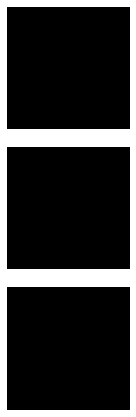

Epoch 38/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


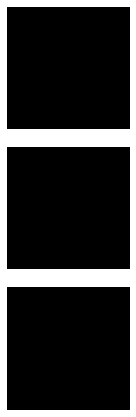

Epoch 39/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


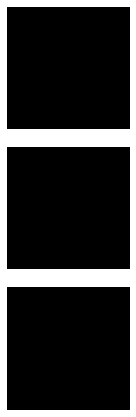

Epoch 40/50
13/13 [==============================] - 2s 160ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


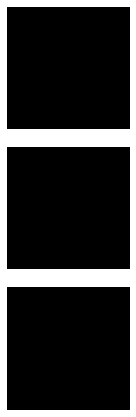

Epoch 41/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


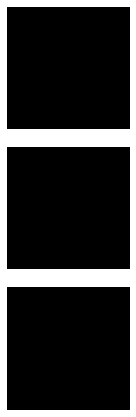

Epoch 42/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


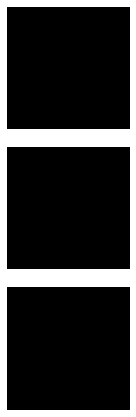

Epoch 43/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


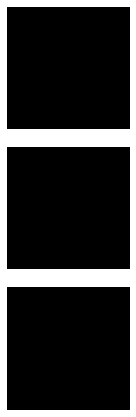

Epoch 44/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


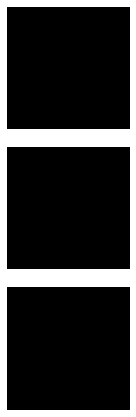

Epoch 45/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


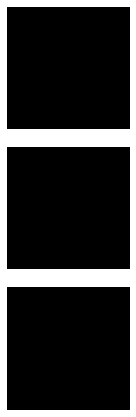

Epoch 46/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


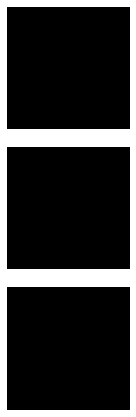

Epoch 47/50
13/13 [==============================] - 2s 160ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


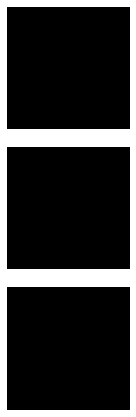

Epoch 48/50
13/13 [==============================] - 2s 158ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


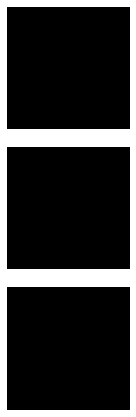

Epoch 49/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


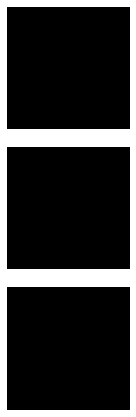

Epoch 50/50
13/13 [==============================] - 2s 159ms/step - n_loss: nan - i_loss: nan - val_n_loss: nan - val_i_loss: nan - val_kid: nan


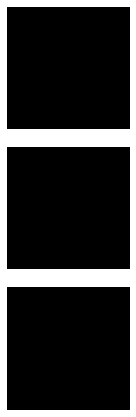

In [23]:
model.fit(
    train_gen,
    epochs=num_epochs,
    validation_data=val_gen,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end = model.plot_images),
        checkpoint_callback,
    ],
)


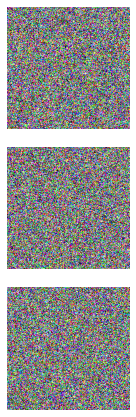

In [24]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()